In [4]:
import copy
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pyod.models.abod import ABOD
from sklearn.neighbors import KernelDensity
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler

In [5]:
def prepare_data(dataframe: pd.DataFrame):
    # Features to del
    features_to_del = ['Perimeter', 'MajorAxisLength', 
                       'MinorAxisLength', 'ConvexArea', 
                       'EquivDiameter', 'AspectRation', 
                       'Eccentricity', 'ShapeFactor3'
                       ]

    abod_detector = ABOD(contamination=0.05, n_neighbors=20, method='fast')
    outliers = abod_detector.fit_predict(dataframe.drop(["Class"], axis=1).to_numpy())
    df_with_detected_outliers = pd.concat([dataframe, pd.DataFrame(outliers, columns=["is_outlier"])], axis=1)
    df_cleaned = df_with_detected_outliers[df_with_detected_outliers["is_outlier"] == 0]
    df_cleaned = df_cleaned.drop(features_to_del, axis=1).drop(["is_outlier"], axis=1)
    scaler = MinMaxScaler()
    df_cleaned.loc[:, df_cleaned.columns != 'Class'] = scaler.fit_transform(df_cleaned.loc[:, df_cleaned.columns != 'Class'])
    return df_cleaned

In [6]:
df = pd.read_excel("../../data/Dry_Bean_Dataset.xlsx")
df_cleaned = prepare_data(df)
df_cleaned.head()

/Users/nikolajfonov/Programming/GitRepositories/comparison-of-bayesian-classifiers/.venv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function fit_predict is deprecated
  warnings.warn(msg, category=FutureWarning)
/var/folders/nm/_vhgd_nn6_q6j0v7y5gyx2p40000gn/T/ipykernel_31328/749219750.py:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.04352619 0.0453764  0.04890216 ... 0.11853861 0.11858227 0.11864777]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_cleaned.loc[:, df_cleaned.columns != 'Class'] = scaler.fit_transform(df_cleaned.loc[:, df_cleaned.columns != 'Class'])


,Area,Extent,Solidity,roundness,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor4,Class
0,0.043526,0.671024,0.838660,0.922035,0.786733,0.573722,0.828019,0.971414,SEKER
1,0.045376,0.735504,0.725580,0.752553,0.903549,0.525508,0.966331,0.963094,SEKER
2,0.048902,0.716671,0.859193,0.897738,0.773514,0.561753,0.794945,0.981113,SEKER
3,0.052330,0.731365,0.483377,0.792905,0.829912,0.530710,0.850368,0.843167,SEKER
4,0.053050,0.700538,0.898182,0.986134,0.951583,0.487023,1.000000,0.983945,SEKER


In [7]:
df_cleaned.to_csv("../../data/Dry_Bean_Dataset_cleaned.csv")

In [8]:
x = df_cleaned.drop(["Class"], axis=1).to_numpy()
y = df_cleaned["Class"].to_numpy()

# Kernel comparison (4.1)

In [9]:
class Kernel:
    _kernels: list[KernelDensity]

    def __init__(self, kernel_type, bandwidth, dim):
        self._kernels = []
        for _ in range(dim):
            self._kernels.append(KernelDensity(kernel=kernel_type, bandwidth=bandwidth))
    
    def fit(self, x):
        for i in range(len(self._kernels)):
            self._kernels[i].fit(x[:,i].reshape((-1, 1)))
        
    def predict(self, x):
        result = []
        for i in range(len(self._kernels)):
            result.append(np.exp(self._kernels[i].score_samples(x[:,i].reshape((-1, 1)))))
        return np.array(result).T
    
    def predict_part(self, x, kde_num):
        return np.exp(self._kernels[kde_num].score_samples(x.reshape((-1, 1))))
    
    @property
    def dim(self):
        return len(self._kernels)

In [10]:
kernel_types = ["gaussian", "tophat", "epanechnikov", "exponential", "linear"]
bandwidths = [0.05, 0.1, 0.2, "silverman", 0.5, 1]

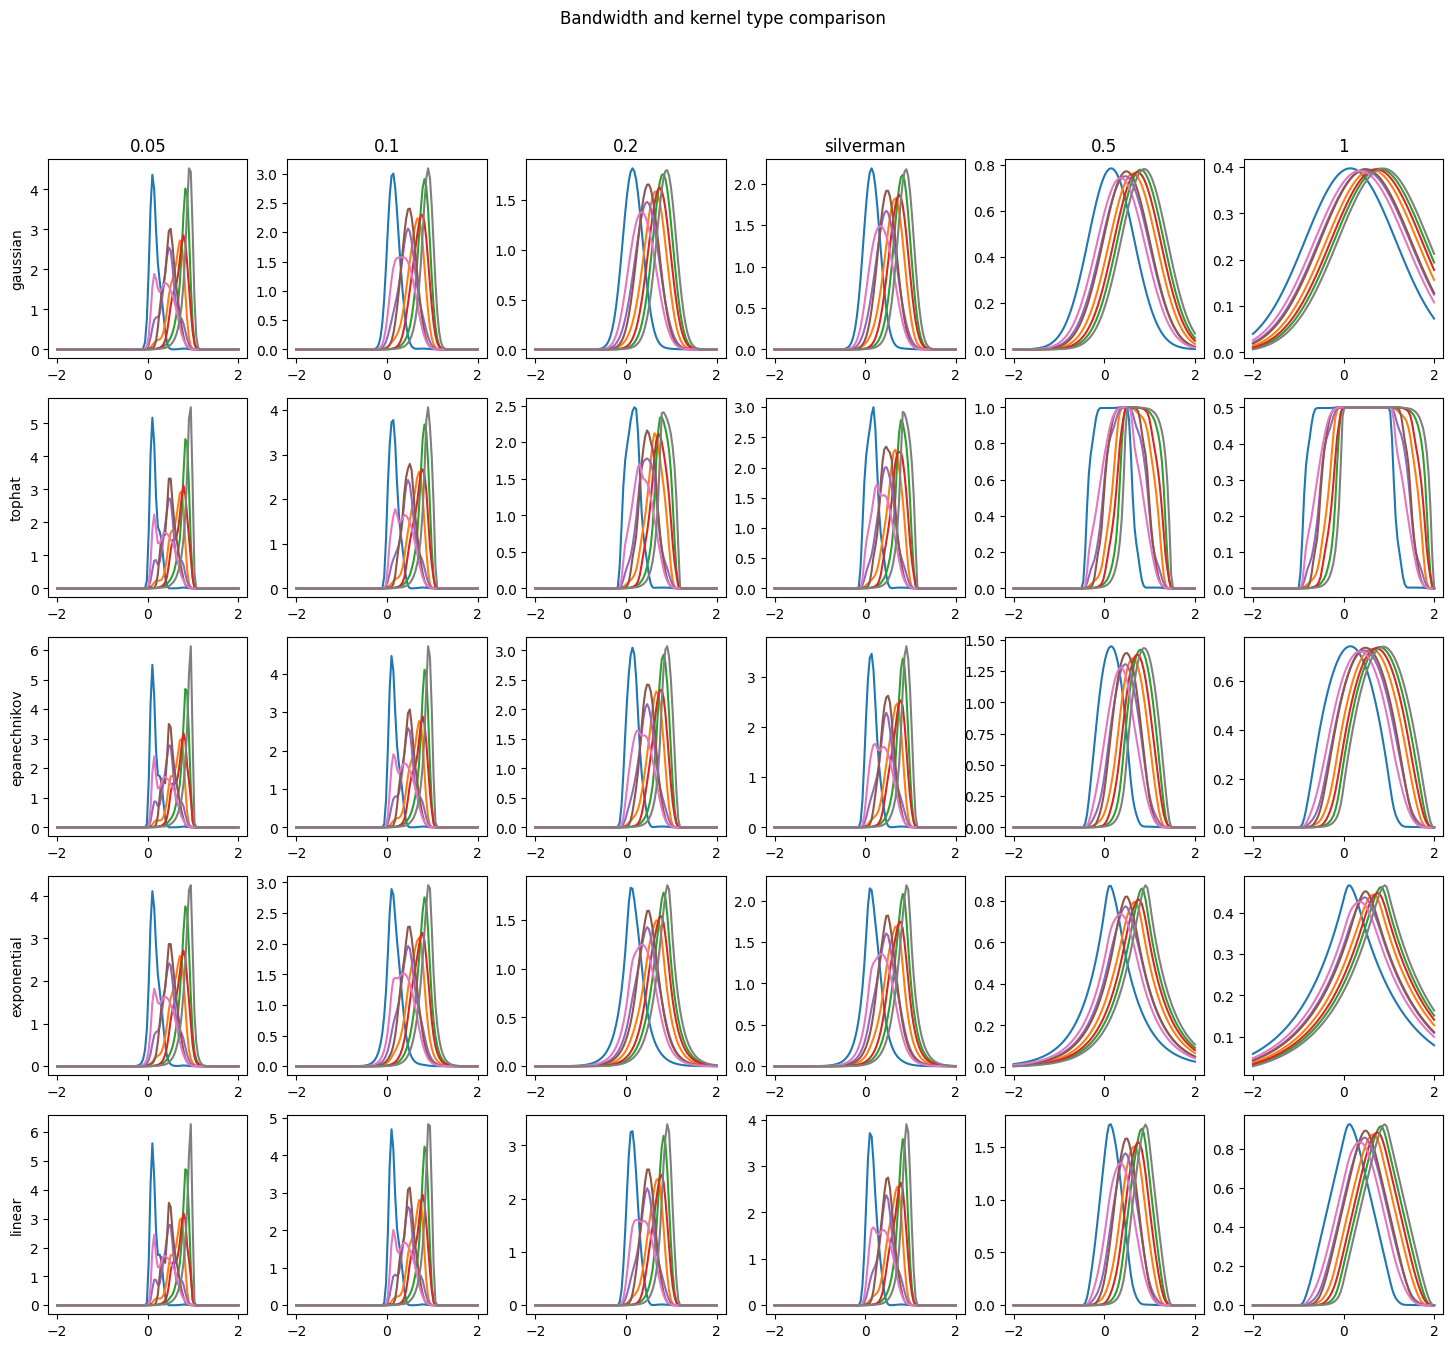

In [11]:
plt.figure(figsize=(18, 15))
#plt.tight_layout()

for i, j in itertools.product(range(len(kernel_types)), range(len(bandwidths))):
    plt.subplot(len(kernel_types), len(bandwidths), (i) * (len(kernel_types) + 1) + j + 1)
    kernel = Kernel(kernel_types[i], bandwidths[j], x.shape[1])
    kernel.fit(x)
    t = np.repeat(np.linspace(-2, 2, 100), kernel.dim).reshape(-1, kernel.dim)
    kde_pred = kernel.predict(t)
    plt.plot(t, kde_pred)
    if i == 0:
        plt.title(f"{bandwidths[j]}")
    if j == 0:
        plt.ylabel(f"{kernel_types[i]}")
plt.suptitle("Bandwidth and kernel type comparison")
plt.show()


# Nonparametric Bayes

Rule:
$$k^*=\arg\max_{k=\overline{1,K}}\tilde f_X(x|k)\tilde p_Y(k)$$
where:
- $\tilde p_Y(k) = \frac{n_y}{n}$;
- $ \tilde f(x)=\prod_{j=1}^M\tilde f_j(x_j)=\frac{1}{n^Mh_1*...*h_M}\prod_{j=1}^M\sum_{i=1}^nK(\frac{x_j-x_{ji}}{h_j})$;
- K – kernel.

In [53]:
from sklearn.base import BaseEstimator

# Nonparametric Bayes
class BayesianNonparametricalModel(BaseEstimator):
    _kernel_class: type
    _kernel_params: dict
    _kernel_instances: dict[str, KernelDensity]
    _klass_probabilities: dict
    _classes: np.ndarray


    def __init__(self, kernel_params: dict) -> None:
        self._kernel_class = KernelDensity
        self._kernel_params = kernel_params
        self._kernel_instances = {}

    def fit(self, x, y) -> None:
        if x.shape[0] != y.shape[0]:
            raise Exception
        
        self._classes, counts = np.unique(y, return_counts=True)
        klass_probs = counts / np.sum(counts)
        self._klass_probabilities = {self._classes[i]: klass_probs[i] for i in range(len(klass_probs))}

        for klass in self._classes:
            klass_indexes = np.where(y == klass)
            x_k = x[klass_indexes]
            y_k = y[klass_indexes]
            
            kernel_k = self._kernel_class(**self._kernel_params)
            kernel_k.fit(x_k)
            self._kernel_instances[klass] = kernel_k
            self._is_fitted = True
            
    def predict_proba(self, x) -> np.ndarray:
        probs_arr = []
        for klass in self._classes:
            f_xk = np.exp(self._kernel_instances[klass].score_samples(x))
            f_k = self._klass_probabilities[klass]
            p_k = f_xk * f_k
            probs_arr.append(p_k)
        probs_arr = np.array(probs_arr).T # [[first element], ... , [last element]]
        norm_values = probs_arr.sum(axis=1)
        norm_values[norm_values == 0] = 1
        probs = probs_arr / norm_values[:, None]
        return probs

    def predict(self, x) -> np.ndarray:
        probs = self.predict_proba(x)
        indexes_max_elements = probs.argmax(axis=1)
        return self._classes[indexes_max_elements]
    
    @property
    def n_classes(self):
        return len(self._classes)
    
    @property
    def classes(self):
        return copy.copy(self._classes)
    
    @property
    def klass_probabilities(self):
        return copy.copy(self._klass_probabilities)
    
    @property
    def kernel_params(self):
        return copy.copy(self._kernel_params)
    
    def __sklearn_is_fitted__(self):
        """
        Check fitted status and return a Boolean value.
        """
        return hasattr(self, "_is_fitted") and self._is_fitted
    


In [72]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=True)

kernel_params = {
    "kernel": "linear",
    "bandwidth": "silverman"
}
bnm = BayesianNonparametricalModel(kernel_params)
bnm.fit(X_train, y_train)
pred = bnm.predict(X_test)

accuracy_score(y_test, pred)

0.7575406032482599

In [73]:
def get_std_mean(kernels):
    res_dict = {kernel: [] for kernel in kernels}
    kf = KFold(n_splits=10, shuffle=True)
    for kernel in kernels:
        for i, (train_index, test_index) in enumerate(kf.split(x)):
            kernel_params = {
                "kernel": kernel,
                "bandwidth": "silverman"
            }
            bnm = BayesianNonparametricalModel(kernel_params)
            bnm.fit(x[train_index], y[train_index])
            pred = bnm.predict(x[test_index])

            
            res_dict[kernel].append(accuracy_score(y[test_index], pred))
    return res_dict

res = get_std_mean(kernels=kernel_types)

In [74]:
pd.DataFrame(res).describe().loc[["mean", "std"]]

,gaussian,tophat,epanechnikov,exponential,linear
mean,0.293426,0.462800,0.705491,0.274401,0.761717
std,0.010773,0.014716,0.014292,0.011902,0.009198


In [73]:
def get_std_mean(kernels, bandwith):
    res_mean_dict = {kernel: [] for kernel in kernels}
    res_std_dict = {kernel: [] for kernel in kernels}
    kf = KFold(n_splits=10, shuffle=True)
    for kernel in kernels:
        for bw in bandwith:
            bw_res = []
            for i, (train_index, test_index) in enumerate(kf.split(x)):
                kernel_params = {
                    "kernel": kernel,
                    "bandwidth": bw
                }
                bnm = BayesianNonparametricalModel(kernel_params)
                bnm.fit(x[train_index], y[train_index])
                pred = bnm.predict(x[test_index])

                
                bw_res.append(accuracy_score(y[test_index], pred))
            res_mean_dict[kernel].append(np.mean(bw_res))
            res_std_dict[kernel].append(np.std(bw_res))
    return res_mean_dict, res_std_dict

res = get_std_mean(kernels=kernel_types, bandwith=bandwidths)

In [74]:
print("Mean")
pd.DataFrame(res[0], index=bandwidths)

Mean


,gaussian,tophat,epanechnikov,exponential,linear
0.05,0.919567,0.697138,0.702862,0.908121,0.712838
0.1,0.905646,0.888090,0.890951,0.886002,0.890255
0.2,0.855916,0.906110,0.912065,0.807502,0.912606
silverman,0.293117,0.463496,0.706419,0.274710,0.761253
0.5,0.336814,0.494741,0.783449,0.384764,0.826991
1,0.273086,0.274633,0.307579,0.273086,0.348492


In [75]:
print("STD")
pd.DataFrame(res[1], index=bandwidths)

STD


,gaussian,tophat,epanechnikov,exponential,linear
0.05,0.007458,0.014630,0.006205,0.005174,0.015858
0.1,0.008423,0.011101,0.008387,0.005372,0.009681
0.2,0.009158,0.008731,0.010048,0.006530,0.005545
silverman,0.016019,0.014453,0.007548,0.010265,0.009989
0.5,0.014123,0.012881,0.012675,0.020713,0.008480
1,0.011510,0.008650,0.008852,0.006648,0.016491


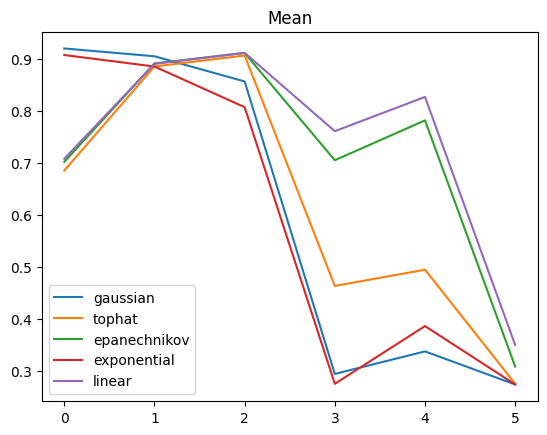

In [91]:
for kernel in kernel_types:
    plt.plot(res[0][kernel], label=kernel)
    plt.legend()
    plt.title("Mean")

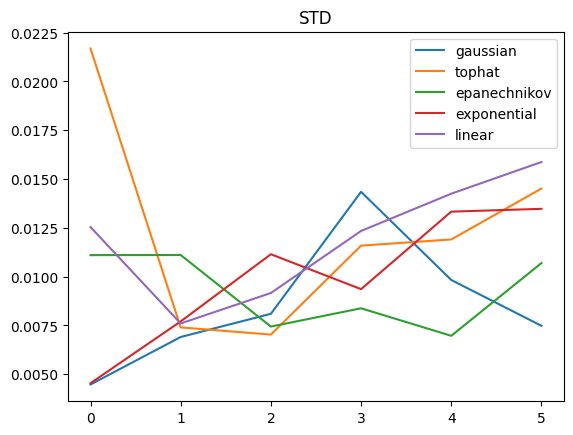

In [92]:
for kernel in kernel_types:
    plt.plot(res[1][kernel], label=kernel)
    plt.legend()
    plt.title("STD")

In [13]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
y_n = le.fit_transform(y)

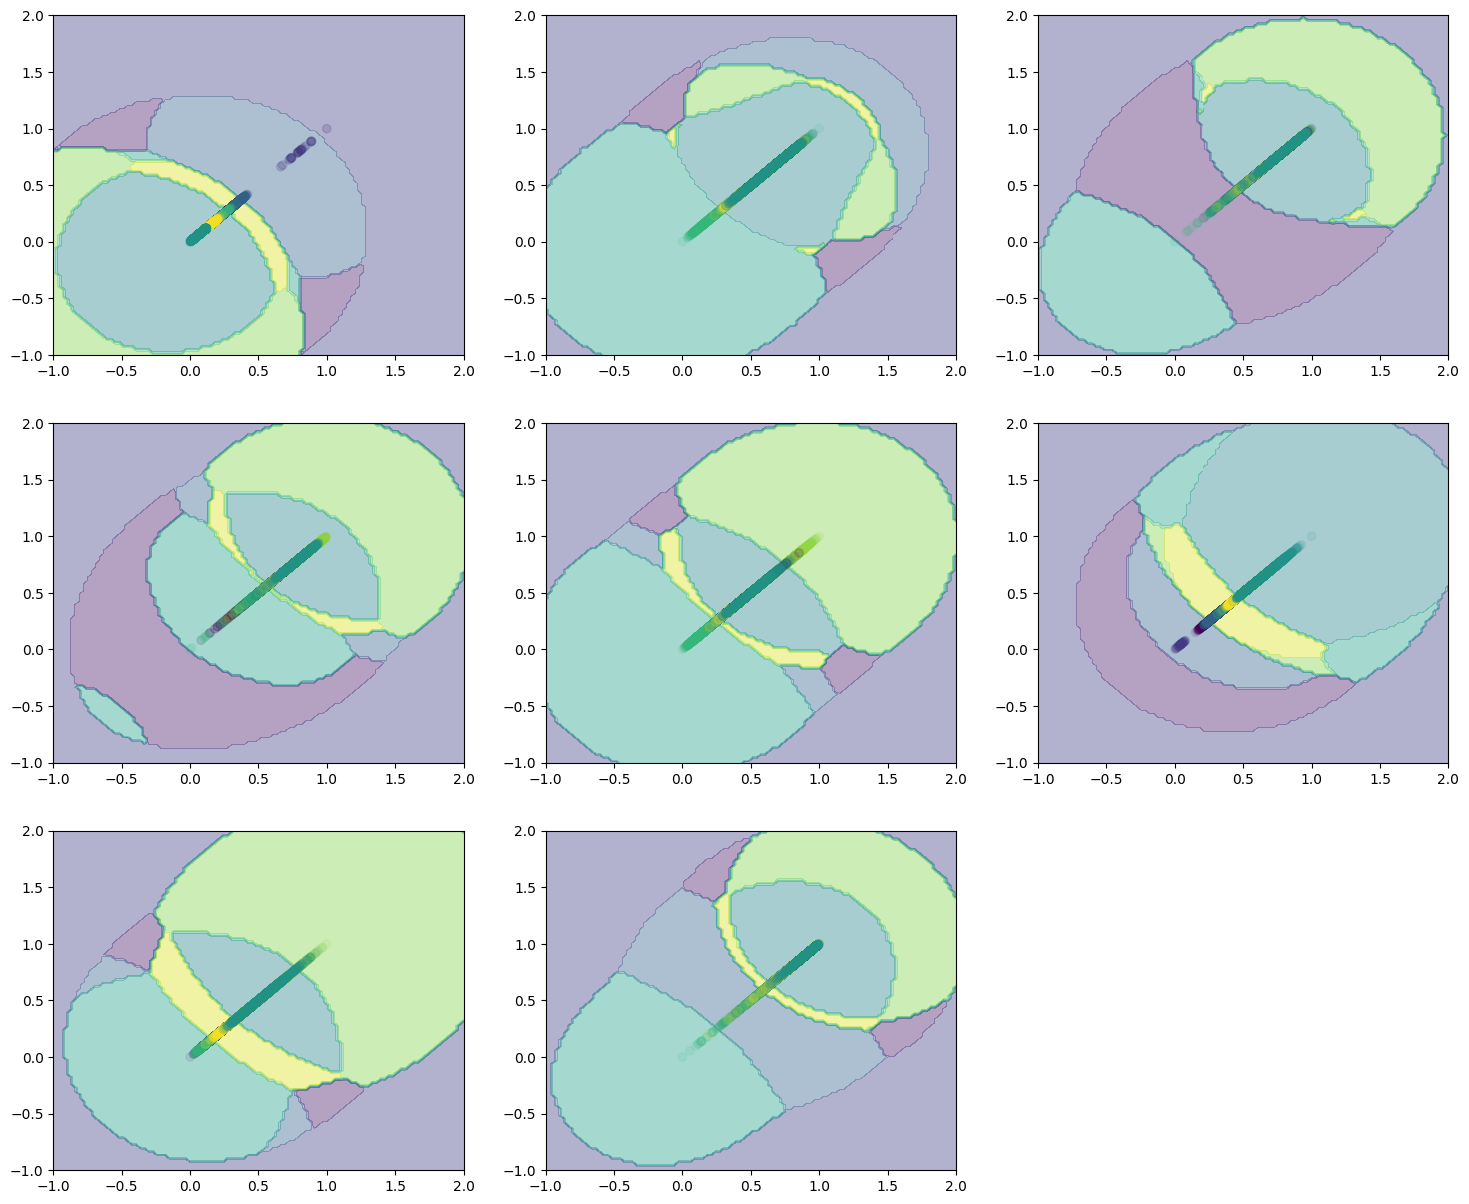

In [24]:
from sklearn.inspection import DecisionBoundaryDisplay


kernel_params = {
                    "kernel": kernel_types[0],
                    "bandwidth": bandwidths[3]
                }

plt.figure(figsize=(18, 15))
#plt.tight_layout()
for i in range(x.shape[1]):
    ax = plt.subplot(3, 3, i + 1)
    x_2 = x[:, [i, i]].astype(float)
    bnm = BayesianNonparametricalModel(kernel_params)
    bnm.fit(x_2, y_n)
    # Plotting decision regions
    DecisionBoundaryDisplay.from_estimator(bnm, x_2, alpha=0.4, ax=ax, response_method="predict")
    plt.scatter(x_2[:,0], x_2[:,1], c=y_n, alpha=0.1)
plt.show()

# 5. ROC curve

In [32]:
from sklearn.preprocessing import LabelBinarizer

label_binarizer = LabelBinarizer().fit(y)
y_onehot_test = label_binarizer.transform(y)
y_onehot_test.shape  # (n_samples, n_classes)

(12930, 7)

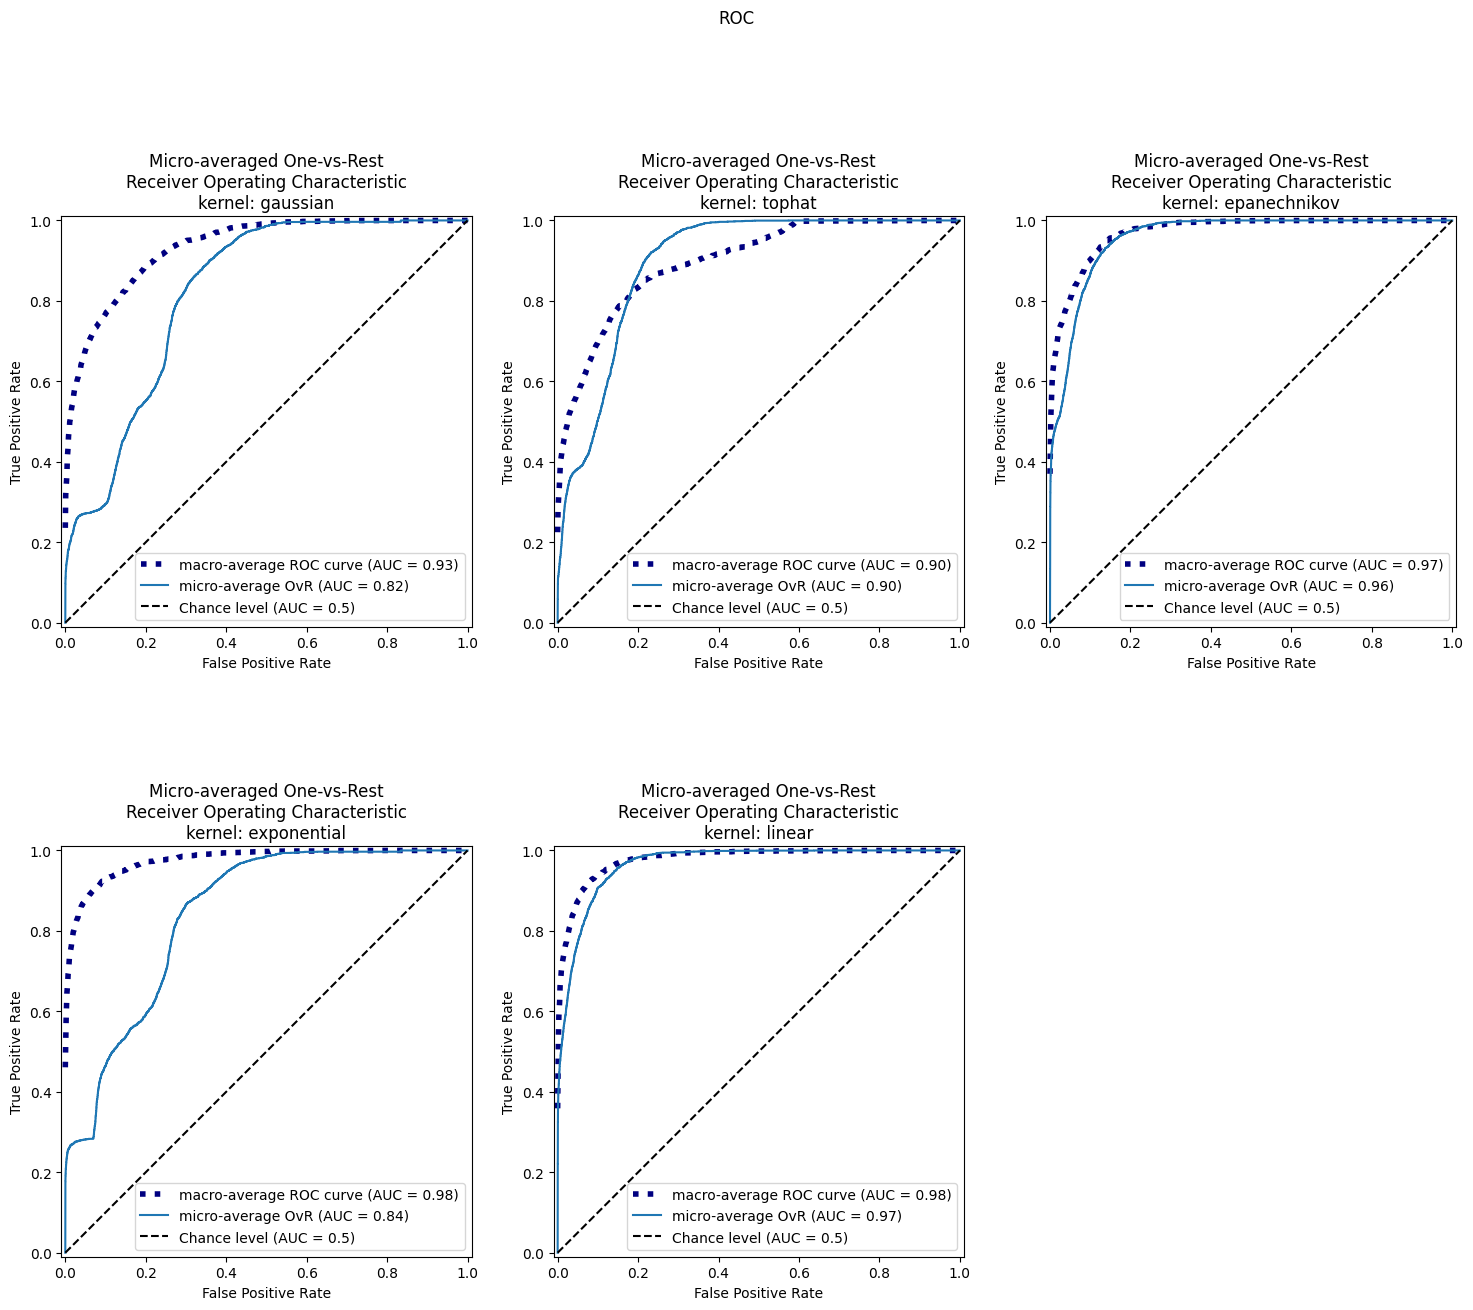

In [61]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import auc, roc_curve


plt.figure(figsize=(18, 15))
#plt.tight_layout()

for i in range(len(kernel_types)):
    ax = plt.subplot(len(kernel_types) // 2, len(kernel_types) // 2 + 1, i + 1)
    kernel_params = {
                    "kernel": kernel_types[i],
                    "bandwidth": "silverman"
                }
    indices = np.arange(len(x))
    X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(x, y, indices, test_size=0.2)

    bnm = BayesianNonparametricalModel(kernel_params)
    bnm.fit(X_train, y_train)
    y_score = bnm.predict_proba(X_test)

    fpr, tpr, roc_auc = dict(), dict(), dict()
    for j in range(bnm.n_classes):
        fpr[j], tpr[j], _ = roc_curve(y_onehot_test[indices_test][:, j], y_score[:, j])
        roc_auc[j] = auc(fpr[j], tpr[j])

    fpr_grid = np.linspace(0.0, 1.0, 1000)

    # Interpolate all ROC curves at these points
    mean_tpr = np.zeros_like(fpr_grid)

    for j in range(bnm.n_classes):
        mean_tpr += np.interp(fpr_grid, fpr[j], tpr[j])  # linear interpolation

    # Average it and compute AUC
    mean_tpr /= bnm.n_classes

    fpr["macro"] = fpr_grid
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    plt.plot(
    fpr["macro"],
    tpr["macro"],
    label=f"macro-average ROC curve (AUC = {roc_auc['macro']:.2f})",
    color="navy",
    linestyle=":",
    linewidth=4,
    )

    #fpr, tpr, thresholds = metrics.roc_curve(y_test, pred_proba, pos_label=2)
    display = RocCurveDisplay.from_predictions(
        y_onehot_test[indices_test].ravel(),
        y_score.ravel(),
        plot_chance_level=True,
        ax=ax,
        name="micro-average OvR"
    )

    _ = display.ax_.set(
        xlabel="False Positive Rate",
        ylabel="True Positive Rate",
        title=f"Micro-averaged One-vs-Rest\nReceiver Operating Characteristic\nkernel: {kernel_types[i]}",
    )

    
plt.suptitle("ROC")
plt.show()

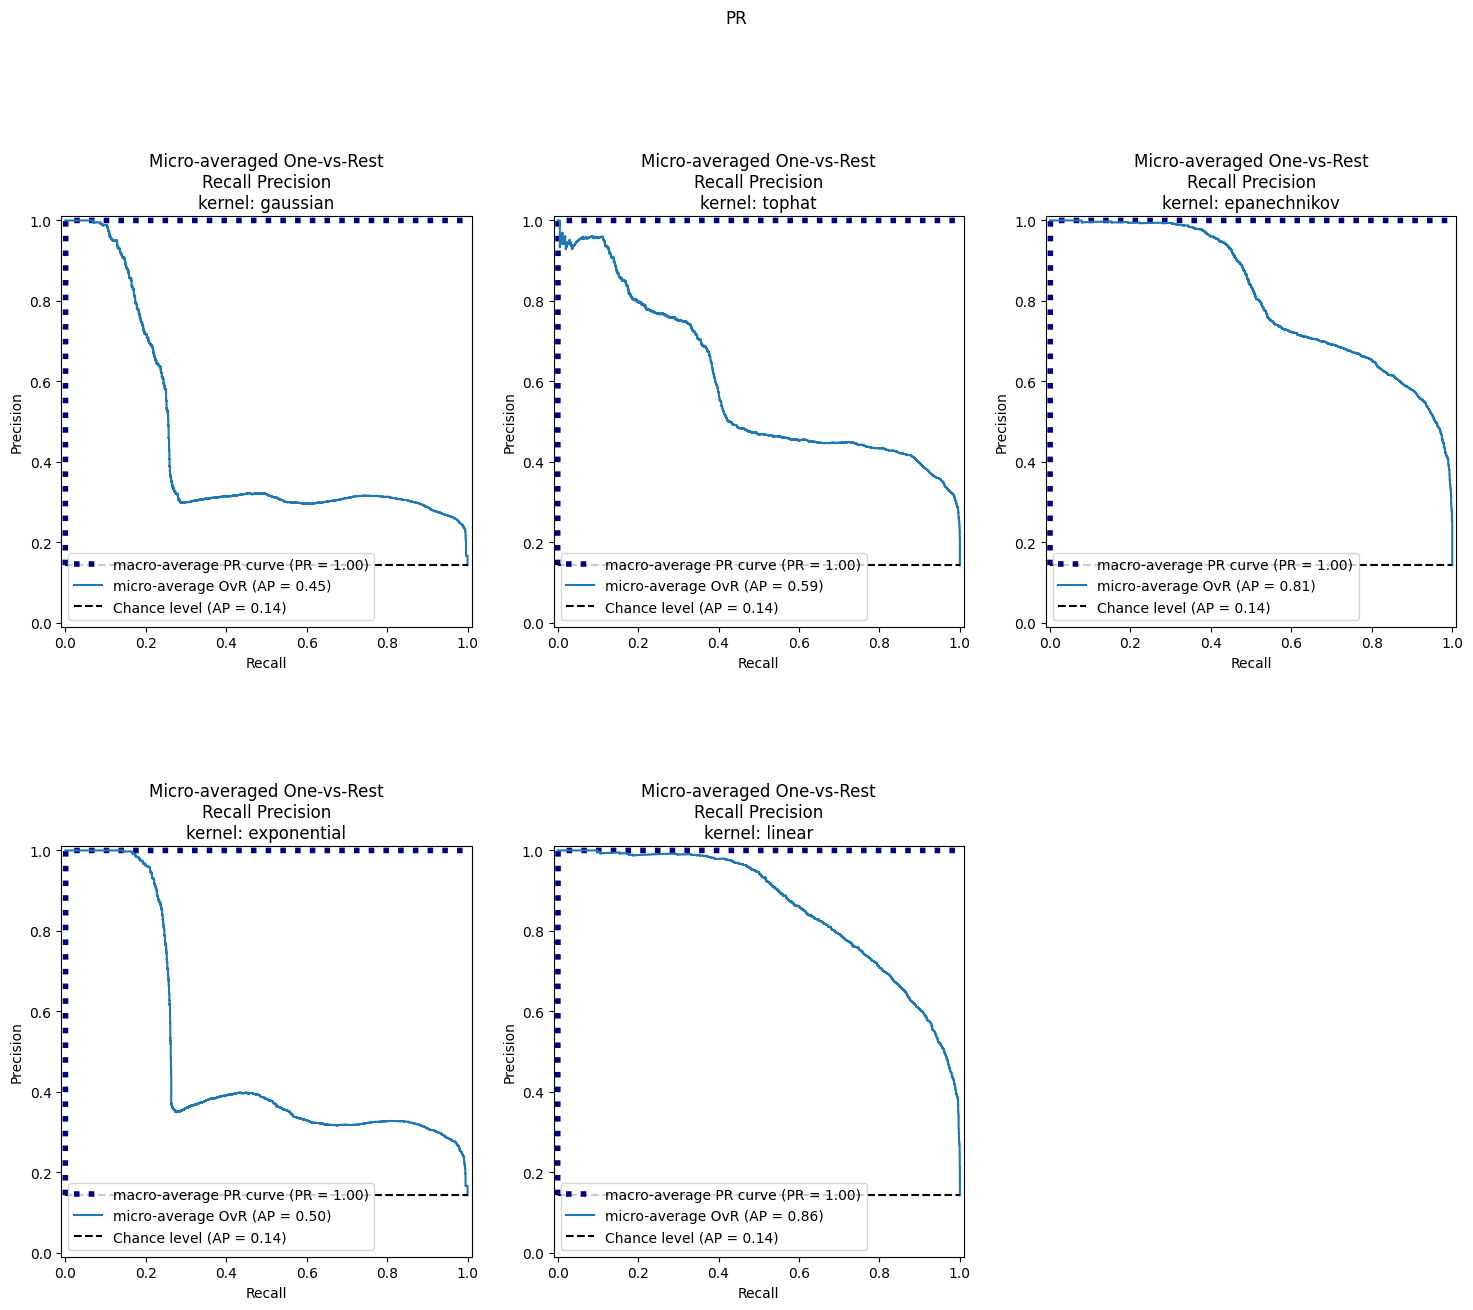

In [67]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay
from sklearn.metrics import precision_recall_fscore_support, precision_recall_curve


plt.figure(figsize=(18, 15))
#plt.tight_layout()

for i in range(len(kernel_types)):
    ax = plt.subplot(len(kernel_types) // 2, len(kernel_types) // 2 + 1, i + 1)
    kernel_params = {
                    "kernel": kernel_types[i],
                    "bandwidth": "silverman"
                }
    indices = np.arange(len(x))
    X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(x, y, indices, test_size=0.2)

    bnm = BayesianNonparametricalModel(kernel_params)
    bnm.fit(X_train, y_train)
    y_score = bnm.predict_proba(X_test)

    precision, recall, pr_auc = dict(), dict(), dict()
    for j in range(bnm.n_classes):
        precision[j], recall[j], _ = precision_recall_curve(y_onehot_test[indices_test][:, j], y_score[:, j])
        pr_auc[j] = auc(recall[j], precision[j])

    recall_grid = np.linspace(0.0, 1.0, 1000)

    # Interpolate all ROC curves at these points
    mean_precision = np.zeros_like(recall_grid)

    for j in range(bnm.n_classes):
        mean_precision += np.interp(recall_grid, recall[j], precision[j])  # linear interpolation

    # Average it and compute AUC
    mean_precision /= bnm.n_classes

    recall["macro"] = recall_grid
    precision["macro"] = mean_precision
    pr_auc["macro"] = auc(recall["macro"], precision["macro"])

    plt.plot(
    recall["macro"],
    precision["macro"],
    label=f"macro-average PR curve (PR = {pr_auc['macro']:.2f})",
    color="navy",
    linestyle=":",
    linewidth=4,
    )

    #fpr, tpr, thresholds = metrics.roc_curve(y_test, pred_proba, pos_label=2)
    display = PrecisionRecallDisplay.from_predictions(
        y_onehot_test[indices_test].ravel(),
        y_score.ravel(),
        plot_chance_level=True,
        ax=ax,
        name="micro-average OvR"
    )

    _ = display.ax_.set(
        xlabel="Recall",
        ylabel="Precision",
        title=f"Micro-averaged One-vs-Rest\nRecall Precision\nkernel: {kernel_types[i]}",
    )

    
plt.suptitle("PR")
plt.show()

# Naive Bayess

In [76]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score


def get_std_mean_gaussiannb():
    scores = []
    kf = KFold(n_splits=10, shuffle=True)
    for i, (train_index, test_index) in enumerate(kf.split(x)):
        gnb = GaussianNB()
        gnb.fit(x[train_index], y[train_index])
        pred = gnb.predict(x[test_index])
        scores.append(accuracy_score(y[test_index], pred))
    return np.mean(scores), np.std(scores)

mean_naive_bayess, std_naive_bayess = get_std_mean_gaussiannb()

# Logistic Regression

In [77]:
from sklearn.linear_model import LogisticRegression


def get_std_mean_logreg():
    scores = []
    kf = KFold(n_splits=10, shuffle=True)
    for i, (train_index, test_index) in enumerate(kf.split(x)):
        gnb = LogisticRegression()
        gnb.fit(x[train_index], y[train_index])
        pred = gnb.predict(x[test_index])
        scores.append(accuracy_score(y[test_index], pred))
    return np.mean(scores), np.std(scores)

mean_log_reg, std_log_reg = get_std_mean_gaussiannb()

# Comparison

In [78]:
print("Naive bayess", mean_naive_bayess, std_naive_bayess)
print("Logistic regression", mean_log_reg, std_log_reg)

Naive bayess 0.9056457849961331 0.006598833413055381
Logistic regression 0.9046403712296982 0.007932863571823082


In [80]:
print("STD")
print(pd.DataFrame(res[1], index=bandwidths))
print("Mean")
print(pd.DataFrame(res[0], index=bandwidths))

STD
           gaussian    tophat  epanechnikov  exponential    linear
0.05       0.007458  0.014630      0.006205     0.005174  0.015858
0.1        0.008423  0.011101      0.008387     0.005372  0.009681
0.2        0.009158  0.008731      0.010048     0.006530  0.005545
silverman  0.016019  0.014453      0.007548     0.010265  0.009989
0.5        0.014123  0.012881      0.012675     0.020713  0.008480
1          0.011510  0.008650      0.008852     0.006648  0.016491
Mean
           gaussian    tophat  epanechnikov  exponential    linear
0.05       0.919567  0.697138      0.702862     0.908121  0.712838
0.1        0.905646  0.888090      0.890951     0.886002  0.890255
0.2        0.855916  0.906110      0.912065     0.807502  0.912606
silverman  0.293117  0.463496      0.706419     0.274710  0.761253
0.5        0.336814  0.494741      0.783449     0.384764  0.826991
1          0.273086  0.274633      0.307579     0.273086  0.348492
